# Analyse ROMY Events - Tilt Correction - One Day

In [2]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
# import multitaper

from obspy.clients.fdsn import Client
from twistpy.tilt.correction import remove_tilt

In [3]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt
from functions.makeplot_waveforms import __makeplot_waveforms

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [5]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## select seismometer ( FUR or DROMY )
config['seis'] = "DROMY"

## Event
# config['event_name'] = "Wind"
# config['tbeg'] = obs.UTCDateTime("2024-03-04 00:00")
# config['tend'] = obs.UTCDateTime("2024-03-05 00:00")
# config['trim'] = [12*3600, 6*3600]

config['event_name'] = "Wind"
config['tbeg'] = obs.UTCDateTime("2024-04-19 00:00")
config['tend'] = obs.UTCDateTime("2024-04-20 00:00")
config['trim'] = [12*3600, 6*3600]

# config['event_name'] = "Wind"
# config['tbeg'] = obs.UTCDateTime("2024-03-27 00:00")
# config['tend'] = obs.UTCDateTime("2024-03-28 00:00")
# config['trim'] = [15*3600, 8*3600]

## Noise
# config['event_name'] = "Noise"
# config['tbeg'] = obs.UTCDateTime("2024-03-29 00:00")
# config['tend'] = obs.UTCDateTime("2024-03-30 00:00")
# config['trim'] = [15*3600, 4*3600]


config['filename'] = f"ROMY_{config['seis']}_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"


## ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941



## Load Data

In [6]:
# config, dist, baz, az = __get_event_info(config)

In [7]:
st0 = obs.read(config['path_to_data']+config['filename'])

st0 = st0.trim(config['tbeg']+config['trim'][0], config['tend']-config['trim'][1])


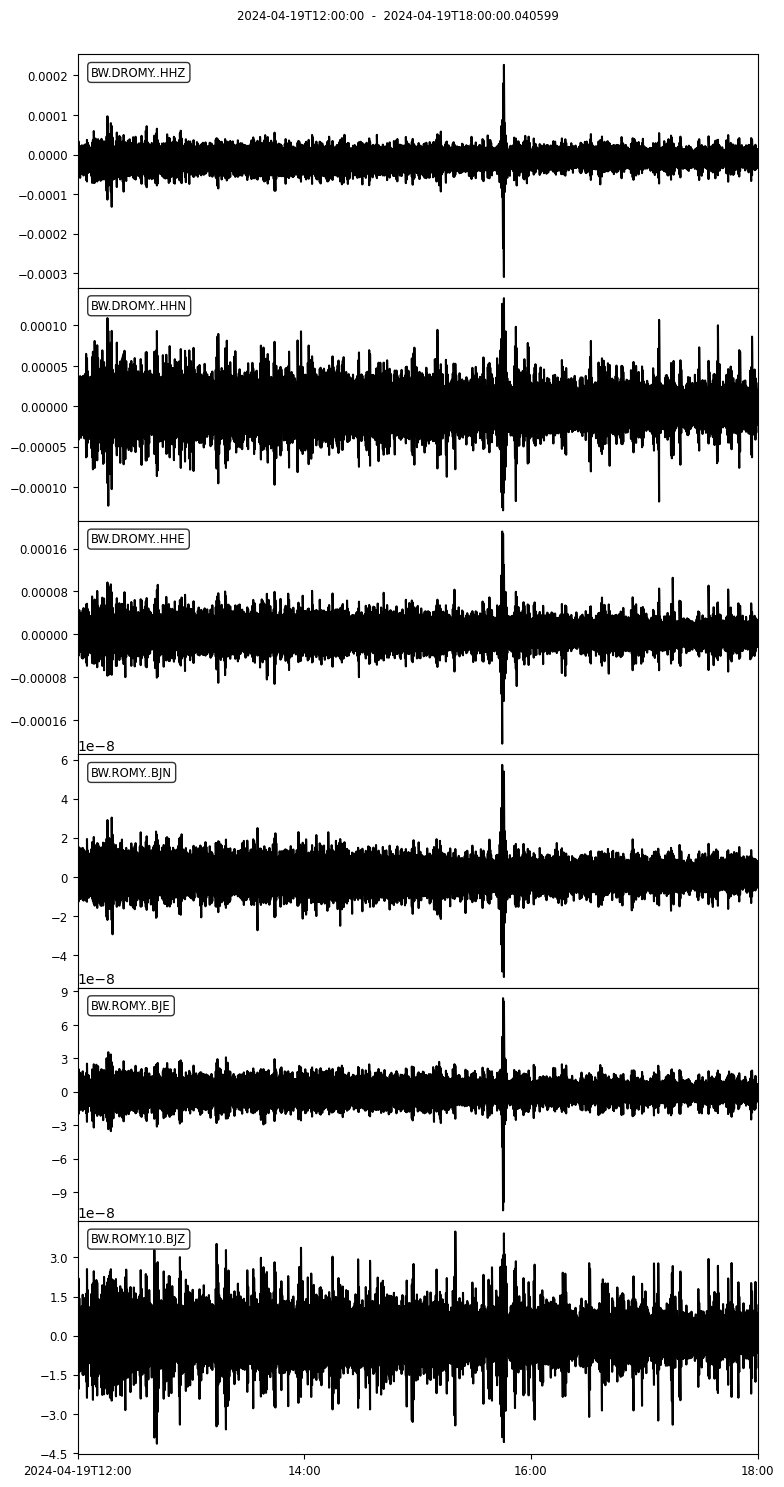

In [8]:
st0.plot(equal_scale=False);

In [9]:
st0

6 Trace(s) in Stream:
BW.ROMY..BJN   | 2024-04-19T12:00:00.015799Z - 2024-04-19T18:00:00.015799Z | 20.0 Hz, 432001 samples
BW.ROMY..BJE   | 2024-04-19T12:00:00.040599Z - 2024-04-19T18:00:00.040599Z | 20.0 Hz, 432001 samples
BW.ROMY.10.BJZ | 2024-04-19T12:00:00.009799Z - 2024-04-19T18:00:00.009799Z | 20.0 Hz, 432001 samples
BW.DROMY..HHE  | 2024-04-19T12:00:00.000000Z - 2024-04-19T18:00:00.000000Z | 20.0 Hz, 432001 samples
BW.DROMY..HHN  | 2024-04-19T12:00:00.000000Z - 2024-04-19T18:00:00.000000Z | 20.0 Hz, 432001 samples
BW.DROMY..HHZ  | 2024-04-19T12:00:00.000000Z - 2024-04-19T18:00:00.000000Z | 20.0 Hz, 432001 samples

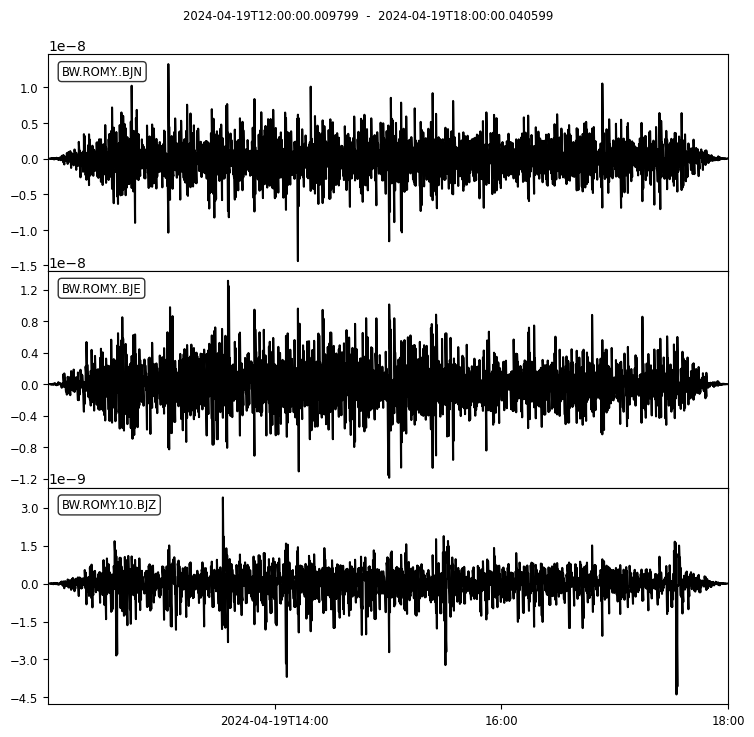

In [10]:
# fmin, fmax = 0.001, 0.01
fmin, fmax = 0.005, 0.1

rot1 = st0.select(station=f"ROMY", channel="*J*").copy()
acc1 = st0.select(station=f"{config['seis']}*", channel="*H*").copy()

rot1 = rot1.detrend("demean").detrend("linear").taper(0.1, type="cosine")
rot1 = rot1.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

acc1 = acc1.detrend("demean").detrend("linear").taper(0.1, type="cosine")
acc1 = acc1.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

til1 = rot1.integrate()

# rot1 = rot1.detrend("demean")

til1.plot(equal_scale=False);


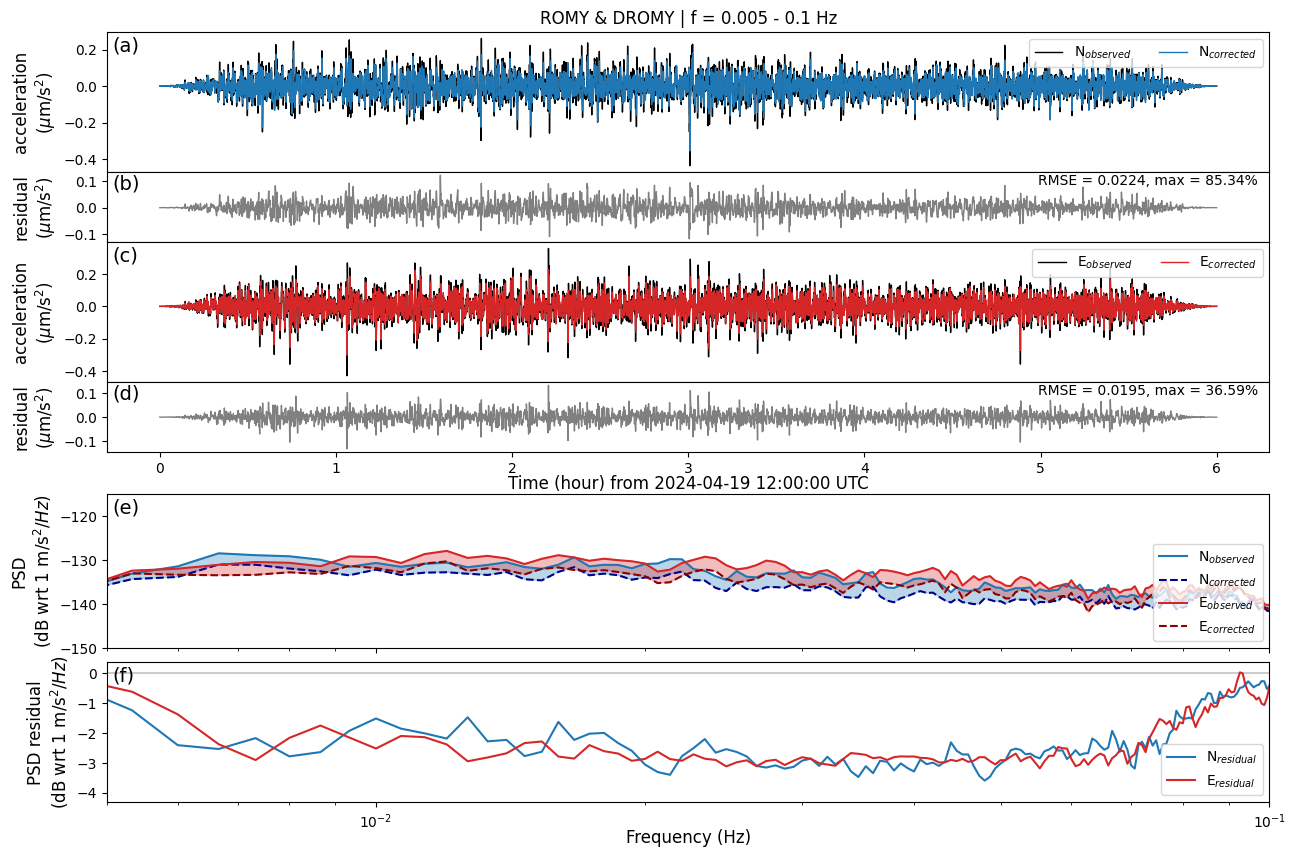

In [14]:
def __makeplot(til_in, acc_in):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __remove_tilt(acc0, rot0, m="freq", scale=1):

        dt = acc0[0].stats.delta

        accN_cor = remove_tilt(acc0.select(channel="*N")[0].data,
                               rot0.select(channel="*E")[0].data,
                               dt,
                               fmin,
                               fmax,
                               parallel=True,
                               # smooth=100.0 / 164.0,
                               method=m,
                               threshold=0.5 # only for coh
                              )

        accE_cor = remove_tilt(acc0.select(channel="*E")[0].data,
                               rot0.select(channel="*N")[0].data,
                               dt,
                               fmin,
                               fmax,
                               parallel=False,
                               # smooth=100.0 / 164.0,
                               method=m,
                               threshold=0.5 # only for coh
                               )

        return accE_cor*scale, accN_cor*scale

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/3600, "hour"

    acc = acc_in.copy()
    til = til_in.copy()

    times = acc.select(channel="*N")[0].times()

    Ncol, Nrow = 1, 11

    font = 12

    lw = 1

    scale, unit = 1e6, f"$\mu$m/s$^2$"

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs2[6:9, :])
    ax6 = fig.add_subplot(gs[9:11, :])

    accN = acc.select(channel="*N")[0].data*scale
    accE = acc.select(channel="*E")[0].data*scale

    # accN = __integrate(acc.copy(), accN)
    # accE = __integrate(acc.copy(), accE)

    accE_c, accN_c = __remove_tilt(acc.copy(), til.copy(), m="coh", scale=scale)

    # accE_c, accN_c = __integrate(acc.copy(), accE_c), __integrate(acc.copy(), accN_c)

    # psd before and after
    dt = acc.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

    fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=1500)
    fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=1500)
    fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=1500)
    fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=1500)

    ax1.plot(times*tscale, accN, color="black", label="N$_{observed}$", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label="N$_{corrected}$", lw=lw)

    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%", lw=lw)


    ax3.plot(times*tscale, accE, color="black", label="E$_{observed}$", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label="E$_{corrected}$", lw=lw)

    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%", lw=lw)


    ax5.plot(fN1, __to_dB(psdN1), label="N$_{observed}$", color="tab:blue")
    ax5.plot(fN2, __to_dB(psdN2), label="N$_{corrected}$", color="darkblue", ls="--")
    ax5.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)

    ax5.plot(fE1, __to_dB(psdE1), label="E$_{observed}$", color="tab:red")
    ax5.plot(fE2, __to_dB(psdE2), label="E$_{corrected}$", color="darkred", ls="--")
    ax5.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)

    # ax5.fill_between(fN1, 0, __to_dB(psdN2) - __to_dB(psdN1), label="N diff", color="tab:blue", alpha=0.4)
    # ax5.fill_between(fE1, 0, __to_dB(psdE2) - __to_dB(psdE1), label="E diff", color="tab:red", alpha=0.4)

    ax5.set_ylim(-150, -115)
    # ax5.set_ylim(-160, -135)
    # ax5.set_ylim(-170, -140)
    ax5.set_xscale("log")
    ax5.set_xlim(fmin, fmax)
    ax5.legend(loc=4)
    ax5.set_xticklabels([])

    diffN = __to_dB(psdN2) - __to_dB(psdN1)
    diffE = __to_dB(psdE2) - __to_dB(psdE1)
    ax6.plot(fN1, diffN, label="N$_{residual}$", color="tab:blue")
    ax6.plot(fE1, diffE, label="E$_{residual}$", color="tab:red")
    # ax6.fill_between(fN1, 0, diffN, label="N$_{residual}$", color="tab:blue", alpha=0.4)
    # ax6.fill_between(fE1, 0, diffE, label="E$_{residual}$", color="tab:red", alpha=0.4)

    ax6.plot([fmin, fmax], [0,0], alpha=0.2, color="k", zorder=0)

    min_lim, max_lim = __get_lim([diffN, diffE])
    ax6.set_ylim(min_lim*1.2, max_lim*1.2)

    ax6.set_xlim(fmin, fmax)
    ax6.set_xscale("log")
    ax6.legend(loc=4)
    ax6.set_ylim()


    for ax in [ax1, ax3]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"acceleration\n({unit})", fontsize=font)
    ax3.set_ylabel(f"acceleration\n({unit})", fontsize=font)
    ax5.set_ylabel(f"PSD\n(dB wrt 1 m/s$^2/Hz$)", fontsize=font)
    ax6.set_ylabel(f"PSD residual\n(dB wrt 1 m/s$^2/Hz$)", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3]:
        ax.get_xaxis().set_visible(False)

#     ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
#     ax4.set_ylabel(f"Residual \n ({tilt_unit})", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {til_in[0].stats.starttime.date} {str(til_in[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=-1)
    ax6.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=-1)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)

    txt = f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

fig = __makeplot(til1, acc1)

fig.savefig(config['path_to_figs']+f"RomyTiltCorrection_{config['event_name']}_{config['tbeg'].date}_{til1[0].stats.station}_{acc1[0].stats.station}.png", format="png", dpi=150, bbox_inches='tight')
